In [1]:
# import das bibliotecas
import os
import pandas as pd
import random
import time
from greedy_filter import *
from math import inf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
# definicao das constantes
PATH_EXCEL = os.getcwd() + '/excel_files/'

In [3]:
dict_excels = {}
filenames = []
excels = []
for filename in os.listdir(PATH_EXCEL):
    filenames.append(filename[:filename.find('.')])
    excels.append(pd.read_excel(PATH_EXCEL + filename).sort_values(by=['Exchange Date']).reset_index(drop=True))
    dict_excels[filename[:filename.find('.')]] = (pd.read_excel(PATH_EXCEL + filename).sort_values(by=['Exchange Date']).reset_index(drop=True))

In [58]:
print(filenames)

['alibaba', 'alphabet', 'amazon', 'apple', 'bitcoin', 'boeing', 'disney', 'facebook', 'microsoft', 'nvidia', 'tesla']


In [59]:
np_array = excels[1].values # Irá utilizar a primeira lista de valores da bolsa

In [6]:
chromossome = [0.07, 10, 14, 51, 0.5]

In [11]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [60]:
def get_average_variation(np_array, window_size, today_index):
    lambda_function = lambda x : abs(x)
    if (today_index > window_size+1):
        slice_array = np_array[today_index - window_size: today_index]
    else:
        slice_array = np_array[1:today_index]
    return lambda_function(slice_array).mean()

In [140]:
def fuzzy_pct_triangle(i_x_filter, i_risk, defuzzy_method):
    # input porcentagem pro ultimo pico
    x_filter = np.arange(0, 1, 0.01)
    x_lo = fuzz.trimf(x_filter, [0, 0, 0.04])
    x_md = fuzz.trimf(x_filter, [0.03, 0.04, 0.05])
    x_hi = fuzz.trapmf(x_filter, [0.04, 0.06, 1, 1])

    # input risco
    x_risk = np.arange(0, 101, 1)
    risk_lo = fuzz.trimf(x_risk, [0, 0, 50])
    risk_md = fuzz.trimf(x_risk, [25, 50, 75])
    risk_hi = fuzz.trimf(x_risk, [50, 100, 100])

    
    # output porcentagem
    x_pct = np.arange(0, 101, 1)
    pct_lo = fuzz.trapmf(x_pct, [0, 0, 25, 50])
    pct_md = fuzz.trimf(x_pct, [25, 50, 75])
    pct_hi = fuzz.trapmf(x_pct, [50, 75, 100, 100])

    
    # ativa o fuzzy no valor do input    
    x_level_lo = fuzz.interp_membership(x_filter, x_lo, i_x_filter)
    x_level_md = fuzz.interp_membership(x_filter, x_md, i_x_filter)
    x_level_hi = fuzz.interp_membership(x_filter, x_hi, i_x_filter)
    risk_level_lo = fuzz.interp_membership(x_risk, risk_lo, i_risk)
    risk_level_md = fuzz.interp_membership(x_risk, risk_md, i_risk)
    risk_level_hi = fuzz.interp_membership(x_risk, risk_hi, i_risk)

    # regras
    # Rule 1 --> high x_filter AND low_risk
    rule1 = np.fmax(x_level_hi, risk_level_lo)
    activation_hi = np.fmin(rule1, pct_hi)
    # Rule 2 --> low x_filter OR high_risk
    rule2 = np.fmin(x_level_lo, risk_level_hi)
    activation_lo = np.fmin(rule2, pct_lo)
    # Rule 3 --> medium x_filter
    activation_md = np.fmin(x_level_md, pct_md)

    # Aggregate all three output membership functions together
    aggregated = np.fmax(activation_lo, np.fmax(activation_md, activation_hi))

    # Calculate defuzzified result
    pct = fuzz.defuzz(x_pct, aggregated, defuzzy_method)
    
    return pct

In [141]:
def fuzzy_risk_triangle(i_vol, i_beta, defuzzy_method):
    # input volatilidade
    x_vol = np.arange(0, 51, 1)
    vol_lo = fuzz.trimf(x_vol, [0, 0, 25])
    vol_md = fuzz.trimf(x_vol, [10, 25, 40])
    vol_hi = fuzz.trimf(x_vol, [30, 50, 50])

    
    # input beta
    x_beta = np.arange(0.9, 1.2, 0.01)
    beta_lo = fuzz.trimf(x_beta, [0.9, 0.9, 1.05])
    beta_md = fuzz.trimf(x_beta, [0.9, 1.05, 1.2])
    beta_hi = fuzz.trimf(x_beta, [1.1, 1.2, 1.2])

    # output risk
    x_risk = np.arange(0, 101, 1)
    risk_lo = fuzz.trimf(x_risk, [0, 0, 50])
    risk_md = fuzz.trimf(x_risk, [30, 70, 100])
    risk_hi = fuzz.trimf(x_risk, [90, 100, 100])

    
    # fuzzyfica os valores
    vol_level_lo = fuzz.interp_membership(x_vol, vol_lo, i_vol)
    vol_level_md = fuzz.interp_membership(x_vol, vol_md, i_vol)
    vol_level_hi = fuzz.interp_membership(x_vol, vol_hi, i_vol)
    beta_level_lo = fuzz.interp_membership(x_beta, beta_lo, i_beta)
    beta_level_md = fuzz.interp_membership(x_beta, beta_md, i_beta)
    beta_level_hi = fuzz.interp_membership(x_beta, beta_hi, i_beta)

    # regras
    # Rule 1 --> low vol OR beta
    rule1 = np.fmax(vol_level_lo, beta_level_lo)
    activation_lo = np.fmin(rule1, risk_lo)
    # Rule 2 --> high vol OR beta
    rule2 = np.fmax(vol_level_hi, beta_level_hi)
    activation_hi = np.fmin(rule2, risk_hi)
    # Rule 3 --> medium vol to medium risk
    activation_md = np.fmin(vol_level_md, risk_md)
    
    # Aggregate all three output membership functions together
    aggregated = np.fmax(activation_lo, np.fmax(activation_md, activation_hi))

    # Calculate defuzzified result
    risk = fuzz.defuzz(x_risk, aggregated, defuzzy_method)

    return risk

In [142]:
#!/usr/bin/env python
# coding: utf-8

# Importação das bibliotecas a serem utilizadas
import pandas as pd
import os, os.path
import random

In [143]:
# Definição de constantes
STOCK_VALUE_INDEX = 1
STOCK_BETA_INDEX = 3
FILTER_RATE_INDEX = 0
FILTER_HOLD_INDEX = 1
FILTER_DELAY_INDEX = 2
FILTER_PREVIOUS_INDEX = 3
FILTER_THRESHOLD_INDEX = 4

In [144]:
def greedy_filter_rule(np_array, filter_rule, money):
    """
        Funcao gulosa para realizar a compra e venda das acoes com base na regra do filtro
        :param: np - array com as informacoes de data e valor das acoes
        :param: filter_rule - parametros da regra de filtro (x,h,d,p)
        :param: money - budget inicial que sera investido
        :return: budget ao final do tempo de investimento
    """
    i = 1
    stock_count = 0
    peaks = findPeakAndValley(np_array)
    stock_count = 0
    while (i < len(np_array)):
        signal_compra = getSignal(np_array, i, filter_rule[FILTER_PREVIOUS_INDEX], peaks, filter_rule[FILTER_RATE_INDEX])
        if (signal_compra > 0):
            stock_count = stock_count + int(signal_compra * money/np_array[i][STOCK_VALUE_INDEX])
            money = money - int(signal_compra * money/np_array[i][STOCK_VALUE_INDEX]) * np_array[i][STOCK_VALUE_INDEX]
            print ("Comprou no dia: "+ str(i)+" totalizando: "+ str(stock_count)+ " e sobrou: "+ str(money))
            i = i + filter_rule[FILTER_HOLD_INDEX]
            while(i < len(np_array)):
                signal_venda = getSignal(np_array, i, filter_rule[FILTER_PREVIOUS_INDEX], peaks, filter_rule[FILTER_RATE_INDEX])
                if (signal_venda < 0):
                    money = money + int(round(stock_count * signal_venda * -1)) * np_array[i][STOCK_VALUE_INDEX]
                    stock_count = stock_count - int(round(stock_count * signal_venda * -1))
                    print ("Vendeu no dia: "+ str(i)+ " e sobrou: " +str(stock_count)+ " e temos: "+ str(money))
                    break
                i = i + filter_rule[FILTER_DELAY_INDEX]
        i = i + 1
    
    return money + stock_count * np_array[len(np_array) - 1][STOCK_VALUE_INDEX]

In [145]:
def getSignal (np, today_index, previous_days, peaks, rate):
    """
        :param: np - array com as informacoes de data e valor das acoes
        :param: today_index - indice do dia a ser analisado
        :param: previous_days - quantidade de dias anteriores(p) que serao usados na analise
        :param: peaks - lista com as datas nas quais houveram picos(ou vales)
        :param: rate - taxa de crescimento
        :return: 1 - sinal de compra/ -1 - sinal de venda / 0 - sinal neutro
    """
    last_index_peak_valley = 0
    last_index = 0
    if (today_index > previous_days):
        for i in range(today_index - previous_days, today_index):
            if i in peaks:
                last_index_peak_valley = i
                if (np[i][STOCK_VALUE_INDEX]/np[i-1][STOCK_VALUE_INDEX] > 1):
                    last_index = 1 # Peak
                else:
                    last_index = -1 # Valley
    else:
        for i in range(0, today_index):
            if i in peaks:
                last_index_peak_valley = i
                if (np[i][STOCK_VALUE_INDEX]/np[i-1][STOCK_VALUE_INDEX] > 1):
                    last_index = 1 # Peak
                else:
                    last_index = -1 # Valley
    percentage_today_last_peak_valey = np[today_index][STOCK_VALUE_INDEX]/np[last_index_peak_valley][STOCK_VALUE_INDEX]
    if(i > 0):
        #print(get_average_variation(np[:,2], previous_days, today_index))
        #print(np[i][STOCK_BETA_INDEX])
        risk = fuzzy_risk_triangle(get_average_variation(np[:,2], previous_days, today_index), np[i][STOCK_BETA_INDEX], 'centroid')
        print("Risk: ", risk, "Percentage", round(abs(percentage_today_last_peak_valey - 1),4))
        percentage = fuzzy_pct_triangle(abs(percentage_today_last_peak_valey - 1), risk, 'lom')
        #print ("Percentage Last PEak: ", abs(percentage_today_last_peak_valey-1))
        if (percentage_today_last_peak_valey > 1 and abs(percentage_today_last_peak_valey - 1) >= rate):
            signal = 1 # Buy
        elif(percentage_today_last_peak_valey < 1 and abs(percentage_today_last_peak_valey - 1) >= rate):
            signal = -1 # Sell
        else:
            signal = 0 # Same price
        #print (percentage, percentage_today_last_peak_valey, rate)
        if(signal == 1 and last_index == -1):
            return 0.01 * percentage
        elif(signal == -1 and last_index == 1):
            return -0.01 * percentage
        else:
            return 0
    else:
        return 0

In [146]:
def get_average_variation(np_array, window_size, today_index):
    lambda_function = lambda x : abs(x)
    if (today_index > window_size+1):
        slice_array = np_array[today_index - window_size: today_index]
    else:
        slice_array = np_array[1:today_index]
    return lambda_function(slice_array).mean()

In [147]:
def findPeakAndValley(np):
    """
        Funcao que encontra todos os picos e vales em um conjunto de dados
        :param: np - dados a serem analisados
        :return: peakValleyArray - array com os picos e vales do conjunto fornecido
    """
    peakValleyArray = []
    for i in range (1, len(np) - 1):
        if (np[i][STOCK_VALUE_INDEX] / np[i - 1][STOCK_VALUE_INDEX] > 1 and np[i + 1][STOCK_VALUE_INDEX] / np[i][STOCK_VALUE_INDEX] < 1):
            peakValleyArray.append(i)
        if (np[i][STOCK_VALUE_INDEX] / np[i - 1][STOCK_VALUE_INDEX] < 1 and np[i + 1][STOCK_VALUE_INDEX] / np[i][STOCK_VALUE_INDEX] > 1):
            peakValleyArray.append(i)
    return peakValleyArray

In [148]:
chromossome = [0.015, 14, 1, 339, 0.5]
money = greedy_filter_rule(np_array, chromossome, 10000)
print (money)

Risk:  17.082824436917445 Percentage 0.0168
Risk:  17.90768960201938 Percentage 0.0235
Risk:  17.766902825155245 Percentage 0.0047
Risk:  17.582170239410363 Percentage 0.0089
Risk:  17.674701232641144 Percentage 0.0021
Risk:  17.469821861295312 Percentage 0.004
Risk:  17.331066849266794 Percentage 0.0011
Risk:  17.21359162663363 Percentage 0.0008
Risk:  17.122284272662693 Percentage 0.0043
Risk:  17.114894667036793 Percentage 0.0099
Risk:  17.13083340916229 Percentage 0.0233
Risk:  17.446997092114497 Percentage 0.0088
Risk:  17.489284714935287 Percentage 0.0132
Risk:  17.454273905103022 Percentage 0.0232
Risk:  17.507897161454995 Percentage 0.0301
Comprou no dia: 16 totalizando: 10 e sobrou: 294.5
Risk:  17.7190315282105 Percentage 0.0106
Risk:  17.937701347342028 Percentage 0.0241
Risk:  18.055077567787876 Percentage 0.0531
Risk:  18.03131019244853 Percentage 0.0061
Risk:  17.924091426656656 Percentage 0.007
Risk:  17.90491611041183 Percentage 0.0128
Risk:  17.869687226835122 Percenta

# ^^^ ATÉ AQUI É ATÔMICO, JÁ ESTÁ TUDO EM FUNÇÃO HEHEHE ^^^

#### Definições importantes que vão pro relatório
1. **Risk:** Risk takes on many forms but is broadly categorized as the chance an outcome or investment's actual return will differ from the expected outcome or return. Risk includes the possibility of losing some or all of the original investment.
2. **Beta:** By definition, the market has a beta of 1.0, and individual stocks are ranked according to how much they deviate from the market. A stock that swings more than the market over time has a beta above 1.0. If a stock moves less than the market, the stock's beta is less than 1.0. High-beta stocks are supposed to be riskier but provide a potential for higher returns; low-beta stocks pose less risk but also lower returns.
3. **Volatilidade:** Standard deviation measures the dispersion of data from its expected value. The standard deviation is used in making an investment decision to measure the amount of historical volatility associated with an investment relative to its annual rate of return. It indicates how much the current return is deviating from its expected historical normal returns. For example, a stock that has a high standard deviation experiences higher volatility, and therefore, a higher level of risk is associated with the stock.

### Fuzzy 1 - Compra/Venda de uma *stock*
1. **INPUTS**
    1. Porcentagem de crescimento
        * Universo: Quanto variou o preço da *stock* desde o último pico?
        * Conjunto Fuzzy: baixo, médio, alto
    2. Risco
        * Universo: Qual o risco de se investir nessa *stock* ?
        * Conjunto Fuzzy: baixo, médio, alto
2. **OUTPUTS**
    1. Porcentagem de compra/venda
        * Universo: Qual a porcentagem do *budget* que deve ser gasta com essa ação?
        * Conjunto Fuzzy: muito baixo, baixo, médio, alto e muito alto
3. **RULES**
    * Se a *stock* tem *alto crescimento* e *baixo risco* **ENTÃO** o investimento deve ser *muito alto*
    * Se a *stock* tem *alto crescimento* e *médio risco* **ENTÃO** o investimento deve ser *alto*
    * Se a *stock* tem *alto crescimento* e *alto risco* **ENTÃO** o investimento deve ser *baixo*

    * Se a *stock* tem *médio crescimento* e *baixo risco* **ENTÃO** o investimento deve ser *alto*
    * Se a *stock* tem *médio crescimento* e *médio risco* **ENTÃO** o investimento deve ser *médio*
    * Se a *stock* tem *médio crescimento* e *alto risco* **ENTÃO** o investimento deve ser *baixo*
    
    * Se a *stock* tem *baixo crescimento* e *baixo risco* **ENTÃO** o investimento deve ser *baixo*
    * Se a *stock* tem *baixo crescimento* e *médio risco* **ENTÃO** o investimento deve ser *muito baixo*
    * Se a *stock* tem *baixo crescimento* e *alto risco* **ENTÃO** o investimento deve ser *muito baixo*

define os inputs

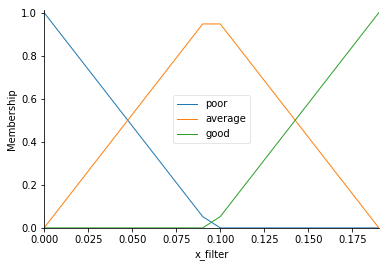

In [2]:
x_filter = ctrl.Antecedent(np.arange(0, 0.20, 0.01), 'x_filter')
x_filter.automf(3)
x_filter.view()

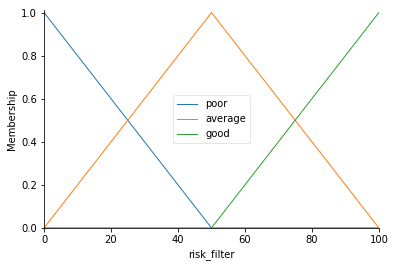

In [3]:
risk_filter = ctrl.Antecedent(np.arange(0,101,1), 'risk_filter')
risk_filter.automf(3)
risk_filter.view()

define os outputs

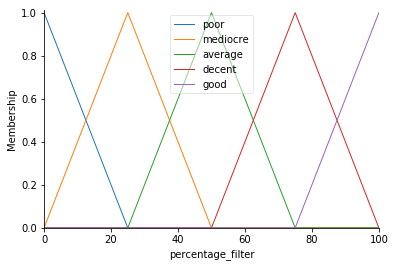

In [4]:
percentage_filter = ctrl.Consequent(np.arange(0,101,1), 'percentage_filter')
percentage_filter.automf(5)
percentage_filter.view()

define as regras

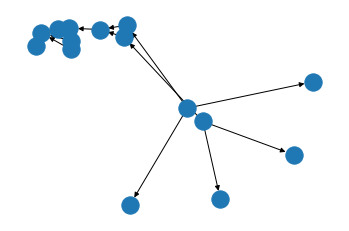

In [11]:
rule1 = ctrl.Rule(x_filter['poor'] | risk_filter['poor'], percentage_filter['good'])
rule2 = ctrl.Rule(x_filter['average'] and risk_filter['average'], percentage_filter['decent'])
rule3 = ctrl.Rule(x_filter['good'] and risk_filter['good'], percentage_filter['mediocre'])
rule4 = ctrl.Rule(x_filter['poor'] and risk_filter['poor'], percentage_filter['decent'])
rule5 = ctrl.Rule(x_filter['average'] and risk_filter['average'], percentage_filter['average'])
rule6 = ctrl.Rule(x_filter['good'] and risk_filter['good'], percentage_filter['mediocre'])
rule7 = ctrl.Rule(x_filter['poor'] and risk_filter['poor'], percentage_filter['mediocre'])
rule8 = ctrl.Rule(x_filter['average'] and risk_filter['average'], percentage_filter['poor'])
rule9 = ctrl.Rule(x_filter['good'] and risk_filter['good'], percentage_filter['poor'])
rule1.view()
plt.show()

cria o controlador fuzzy

In [12]:
calc_pct_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
calc_pct_ctrl

### TESTE DO FUZZY PRO IGU VER

20.83066751972702


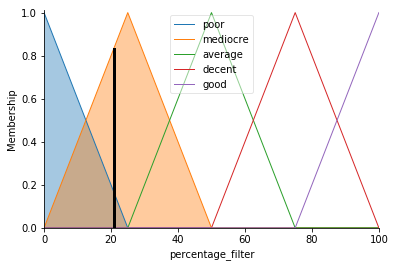

In [13]:
pct = ctrl.ControlSystemSimulation(calc_pct_ctrl)
pct.input['x_filter'] = 200
pct.input['risk_filter'] = 200

pct.compute()

print(pct.output['percentage_filter'])
percentage_filter.view(sim=pct)

### Fuzzy 2 - Classificação do Grau de Risco de uma *stock*
1. **INPUTS**
    1. Média de Variação (famosa volatilidade)
        * Universo: Qual foi a média de variação no valor das *stocks* (em módulo)?
        * Conjunto Fuzzy: baixo, média, alto
    2. Beta
        * Universo: Qual o valor da volatilidade da *stock* com relação a volatilidade do mercado?
        * Conjunto Fuzzy: baixo, alto
2. **OUTPUTS**
    1. Risco
        * Universo: Qual o grau de risco ao se investir nessa *stock* ?
        * Conjunto Fuzzy: baixo, médio, alto
3. **RULES**
    * Se a *stock* apresenta *baixa variação* e um *baixo valor beta* **ENTAO** o risco é baixo
    * Se a *stock* apresenta *baixa variação* e um *alto valor beta* **ENTAO** o risco é médio
    * Se a *stock* apresenta *média variação* e um *baixo valor beta* **ENTAO** o risco é médio
    * Se a *stock* apresenta *média variação* e um *alto valor beta* **ENTAO** o risco é alto
    * Se a *stock* apresenta *alta variação* e um *baixo valor beta* **ENTAO** o risco é médio
    * Se a *stock* apresenta *alta variação* e um *alto valor beta* **ENTAO** o risco é alto

define os inputs

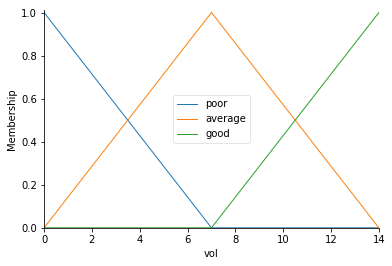

In [14]:
vol =  ctrl.Antecedent(np.arange(0, 15, 1), 'vol')
vol.automf(3)
vol.view()

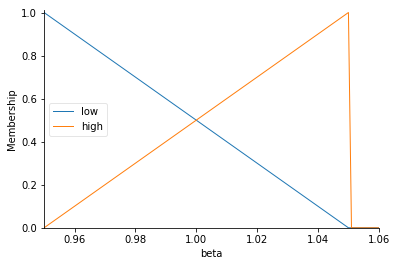

In [15]:
beta = ctrl.Antecedent(np.arange(0.95, 1.06, 0.001), 'beta')
beta['low'] = fuzz.trimf(beta.universe, [0.95, 0.95, 1.05])
beta['high'] = fuzz.trimf(beta.universe, [0.95, 1.05, 1.05])
beta.view()

define os outputs

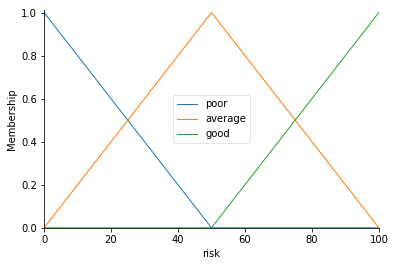

In [16]:
risk = ctrl.Consequent(np.arange(0, 101, 1), 'risk')
risk.automf(3)
risk.view()

define as regras

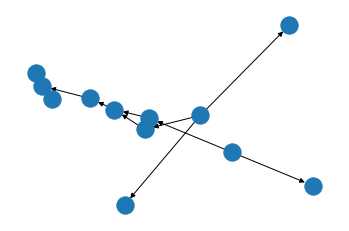

In [27]:
rule1 = ctrl.Rule(vol['poor'] | beta['low'], risk['poor'])
rule2 = ctrl.Rule(vol['poor'] | beta['high'], risk['average'])
rule3 = ctrl.Rule(vol['average'] | beta['low'], risk['average'])
rule4 = ctrl.Rule(vol['average'] | beta['high'], risk['good'])
rule5 = ctrl.Rule(vol['good'] | beta['low'], risk['average'])
rule6 = ctrl.Rule(vol['good'] | beta['high'], risk['good'])
rule1.view()
plt.show()

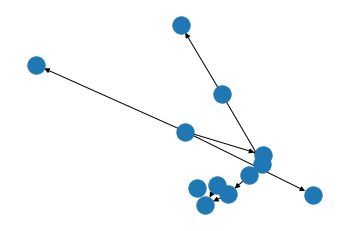

In [37]:
rule1 = ctrl.Rule(vol['poor'] | beta['low'], risk['poor'])
rule2 = ctrl.Rule(vol['good'] | beta['high'], risk['good'])
rule1.view()
plt.show()

cria o controlador fuzzy

In [38]:
calc_risk_ctrl = ctrl.ControlSystem([rule1, rule2])
calc_risk_ctrl

### TESTE DO FUZZY PRO IGU VER

In [59]:
risking = ctrl.ControlSystemSimulation(calc_risk_ctrl)
risking.input['vol'] = 16
risking.input['beta'] = 0.95

risking.compute()

print(risking.output['risk'])

49.999999999999986


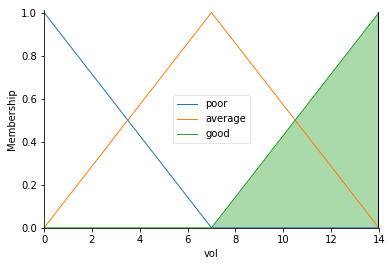

In [60]:
vol.view(sim=risking)

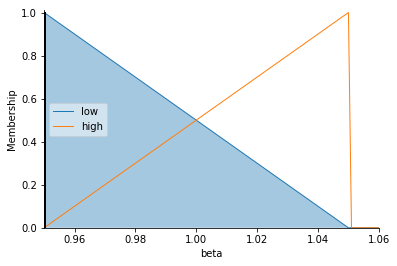

In [61]:
beta.view(sim=risking)